##Заполнение пропущенных значений
В данном ноутбуке исследую различные техники заполнения пропусков в категориальных колонках набора данных

In [2]:
from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

import missingno as msno

%matplotlib inline

In [3]:
data = pd.read_csv('/content/googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
data = data.drop([10472])
data.shape

(10840, 13)

In [5]:
data.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

In [5]:
# Эти признаки выкину, тк они не пригодятся для обучения модели
data.drop(labels = ['Last Updated','Current Ver','Android Ver','App'], axis = 1, inplace = True)

In [7]:
# Преобразую Type в бинарные значения
#def type_cat(types):
#    if types == 'Free':
#        return 0
#    else:
#        return 1

#data['Type'] = data['Type'].map(type_cat)

In [6]:
# Очистка признака size 
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

data["Size"] = data["Size"].map(change_size)

In [7]:
# Очистка признака Installs
data['Installs']=data['Installs'].apply(lambda x: x.strip('+'))
data['Installs']=data['Installs'].apply(lambda x: x.replace(',',''))
data['Installs']=data['Installs'].replace('Free',np.nan)
data['Installs'] = data['Installs'].astype(float)

In [8]:
# Очистка признака Price
data['Price'] = data['Price'].apply(lambda x: x.replace('$',''))
data['Price']=pd.to_numeric(data['Price'])

In [9]:
# преобразую reviews к numeric
data['Reviews'] = data['Reviews'].astype(float)

In [10]:
# Закодирую категориальные признаки в числовые
le = LabelEncoder()
content_rating = data['Content Rating']

category = le.fit_transform(data['Category'].dropna())
genres = le.fit_transform(data['Genres'].dropna())
cont_r = le.fit_transform(data['Content Rating'].dropna())
data['Category_num'] = category
data['Genres_num'] = genres
data['Content Rating'] = cont_r

In [11]:
data.isnull().sum()

Category             0
Rating            1474
Reviews              0
Size              1695
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Category_num         0
Genres_num           0
dtype: int64

Заполню признаки Rating и Size средним значением. Так как его выбрала ранее.

In [12]:
mean_imp = SimpleImputer(strategy="mean")
new_df = data.copy()

new_df["Rating"] = mean_imp.fit_transform(new_df[["Rating"]])
new_df["Size"] = mean_imp.fit_transform(new_df[["Size"]])
new_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              1
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

In [ ]:
new_df.shape

(10840, 11)

Намеренно внесем рандомно пропуски в категориальном признаке Type.

In [13]:
from random import seed
from random import randint
# seed random number generator
seed(1)
rows_indexes = []
# generate some integers
for _ in range(1300):
  value = randint(0, 10840)
  rows_indexes.append(value)
print(rows_indexes)

[2201, 9325, 1033, 4179, 1931, 8117, 7364, 7737, 10675, 6219, 3439, 1537, 7993, 464, 6386, 7090, 9952, 34, 7297, 4363, 3748, 9685, 1674, 5200, 501, 365, 416, 10642, 8870, 150, 6245, 3548, 6915, 475, 8644, 3632, 7174, 8123, 9058, 3818, 5663, 3782, 3584, 7530, 4747, 352, 6818, 9116, 10523, 1638, 3045, 10311, 4856, 1980, 5450, 8205, 6915, 8318, 3110, 4970, 4655, 9626, 8181, 8278, 6444, 9650, 565, 7868, 3977, 6623, 6788, 2834, 6014, 8991, 6139, 1416, 7191, 8330, 1768, 2682, 8535, 6443, 6070, 8023, 484, 7689, 712, 5054, 10073, 9718, 9472, 6448, 10603, 2791, 2762, 8228, 3718, 201, 3268, 8841, 8983, 3803, 6626, 8417, 5633, 9466, 5788, 7522, 4411, 10800, 8978, 9976, 93, 6286, 8396, 2117, 8498, 9197, 3366, 6981, 919, 7882, 5975, 9338, 9083, 3274, 8269, 6773, 7945, 5845, 6789, 5670, 25, 8822, 8849, 10215, 10034, 5425, 7506, 9828, 458, 3761, 10409, 2903, 9023, 9575, 2961, 1500, 9028, 4182, 531, 1154, 1363, 273, 7421, 238, 4607, 4088, 4401, 1793, 10236, 3024, 5643, 4756, 1138, 2743, 2615, 4181, 86

In [14]:
#new_df.Type=new_df.Type.astype(float)
for index in rows_indexes:
  new_df.at[index, 'Type'] = np.nan

In [15]:
new_df.isnull().sum()

Category             0
Rating               0
Reviews              0
Size                 0
Installs             0
Type              1234
Price                0
Content Rating       0
Genres               0
Category_num         0
Genres_num           0
dtype: int64

##Frequent Categorical Imputation

In [16]:
def impute_nan_most_frequent_category(DataFrame, ColName):
    # .mode()[0] - gives first category name
    most_frequent_category=DataFrame[ColName].mode()[0]
    # replace nan values with most occured category
    DataFrame[ColName + "_Imputed"] = DataFrame[ColName]
    DataFrame[ColName + "_Imputed"].fillna(most_frequent_category,inplace=True)

In [17]:
for Columns in ['Type']:
    impute_nan_most_frequent_category(new_df, Columns)

In [18]:
new_df.isnull().sum()

Category             0
Rating               0
Reviews              0
Size                 0
Installs             0
Type              1234
Price                0
Content Rating       0
Genres               0
Category_num         0
Genres_num           0
Type_Imputed         0
dtype: int64

In [19]:
full_df = new_df.copy()
full_df['Type'] = full_df['Type_Imputed']
full_df.drop('Type_Imputed', axis=1, inplace=True)
full_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

Буду кодировать признак Type перед началом обучения модели. Опять выбираю линейную регрессию в качестве модели, на которой буду тестировать разные стратегии заполнения пропусков в данных. Выбор связан с тем, что данная модель простая и рассчеты выполняются достаточно быстро.
Также попробую оценить точность стратегий заполнению пропусков, использую модель Bagging, так как эта модель показала наилучшие результаты в разделе, где я выбирала лучшую модель для своего набора данных.

In [20]:
type_num = le.fit_transform(full_df['Type'])
full_df['Type'] = type_num
print(np.unique(full_df['Type']))

[0 1]


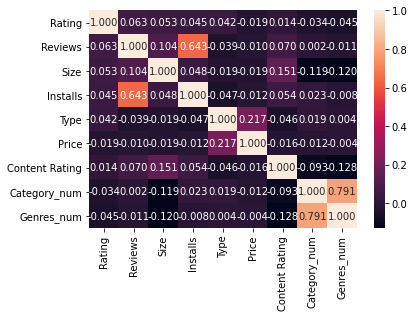

In [ ]:
sns.heatmap(full_df.corr(), annot=True, fmt='.3f')

In [21]:
X = full_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_mode = full_df["Rating"]

In [22]:
columns = X.columns
scaler = StandardScaler()
X_mode = scaler.fit_transform(X)
pd.DataFrame(X_mode, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,8.623458e-16,1.651623e-16,4.424925e-15,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-1.036705e+00,-1.818790e-01,-2.621399e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-7.527294e-01,-1.818672e-01,-2.621399e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-1.694996e-01,-1.807028e-01,-2.621399e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,2.161069e-01,-1.230730e-01,-2.621399e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.782967e+00,1.157931e+01,3.814757e+00,3.513515e+00,1.646057e+00


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_mode, y_mode,
                            test_size=0.2, random_state=88888888)

In [24]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("mean_squared_error:",
          mean_squared_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

In [25]:
lin_mode = LinearRegression()
lin_mode.fit(X_train, y_train)
test_model(lin_mode)

mean_absolute_error: 0.3043701037080406
median_absolute_error: 0.22090960077943622
mean_squared_error: 0.21179434427369973
r2_score: 0.011509155370468926


In [26]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=251,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [27]:
b_gs_mode = gs.best_estimator_
b_gs_mode.fit(X_train, y_train)
y_pred = b_gs_mode.predict(X_test)
test_model(b_gs_mode)

mean_absolute_error: 0.2786805597574532
median_absolute_error: 0.1743192083257754
mean_squared_error: 0.18849791080074238
r2_score: 0.1202387405702513


##Adding Vairable to Capture NAN Value

In [28]:
full_df = new_df.copy()

In [29]:
# Function to impute most occured category and add importance vairable

def impute_nan_add_vairable(DataFrame,ColName):
    # Create new column and replace if category is null then 1 else 0
    DataFrame[ColName+"_Imputed"]=np.where(DataFrame[ColName].isnull(),1,0)
    
    #Take most frequent occured category in that vairable (.mode())
    Mode_Category = DataFrame[ColName].mode()[0]
    
    #Replace NAN values with most occured category in actual vairable
    DataFrame[ColName].fillna(Mode_Category,inplace=True)

In [30]:
for Columns in ['Type']:
    impute_nan_add_vairable(full_df,Columns)

In [31]:
full_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
Type_Imputed      0
dtype: int64

In [32]:
np.unique(full_df['Type'])

array(['Free', 'Paid'], dtype=object)

In [33]:
type_num = le.fit_transform(full_df['Type'])
full_df['Type'] = type_num
print(np.unique(full_df['Type']))

[0 1]


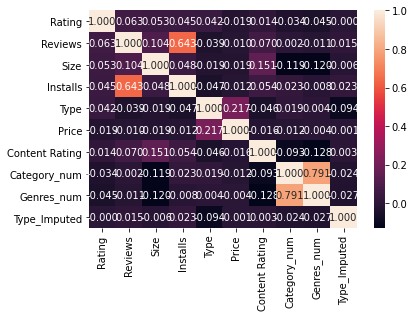

In [ ]:
sns.heatmap(full_df.corr(), annot=True, fmt='.3f')

In [34]:
X = full_df.drop(["Rating", "Type_Imputed", "Price", "Category_num", "Category", "Genres"], axis=1)
y_add_var = full_df["Rating"]

columns = X.columns
scaler = StandardScaler()
X_add_var = scaler.fit_transform(X)
pd.DataFrame(X_add_var, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,8.623458e-16,1.651623e-16,4.424925e-15,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-1.036705e+00,-1.818790e-01,-2.621399e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-7.527294e-01,-1.818672e-01,-2.621399e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-1.694996e-01,-1.807028e-01,-2.621399e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,2.161069e-01,-1.230730e-01,-2.621399e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.782967e+00,1.157931e+01,3.814757e+00,3.513515e+00,1.646057e+00


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_add_var, y_add_var,
                            test_size=0.2, random_state=88888888)

In [36]:
lin_add_var = LinearRegression()
lin_add_var.fit(X_train, y_train)
test_model(lin_add_var)

mean_absolute_error: 0.3043701037080406
median_absolute_error: 0.22090960077943622
mean_squared_error: 0.21179434427369973
r2_score: 0.011509155370468926


In [37]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=241,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [38]:
b_gs_add_var = gs.best_estimator_
b_gs_add_var.fit(X_train, y_train)
y_pred = b_gs_add_var.predict(X_test)
test_model(b_gs_add_var)

mean_absolute_error: 0.2792396195254479
median_absolute_error: 0.175092437287506
mean_squared_error: 0.18758910307242768
r2_score: 0.12448034636972782


##Create a New Category for NAN Values

In [39]:
full_df = new_df.copy()
#print(np.unique(full_df['Type']))

In [ ]:
full_df.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_num,Genres_num,Type_Imputed
0,ART_AND_DESIGN,4.1,159.0,19000000.0,10000.0,Free,0.0,1,Art & Design,0,9,Free
1,ART_AND_DESIGN,3.9,967.0,14000000.0,500000.0,Free,0.0,1,Art & Design;Pretend Play,0,12,Free
2,ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000.0,Free,0.0,1,Art & Design,0,9,Free
3,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000.0,Free,0.0,4,Art & Design,0,9,Free
4,ART_AND_DESIGN,4.3,967.0,2800000.0,100000.0,Free,0.0,1,Art & Design;Creativity,0,11,Free


In [40]:
#1. Function to impute null value with new category
def impute_nan_create_category(DataFrame,ColName):
    DataFrame[ColName]=np.where(DataFrame[ColName].isnull(),"Unknown",DataFrame[ColName])

In [41]:
## Call function to create new category for variables
for Columns in ['Type']:
    impute_nan_create_category(full_df,Columns)

In [42]:
np.unique(full_df['Type'])

array(['Free', 'Paid', 'Unknown'], dtype=object)

In [43]:
type_num = le.fit_transform(full_df['Type'])
full_df['Type'] = type_num
print(np.unique(full_df['Type']))

[0 1 2]


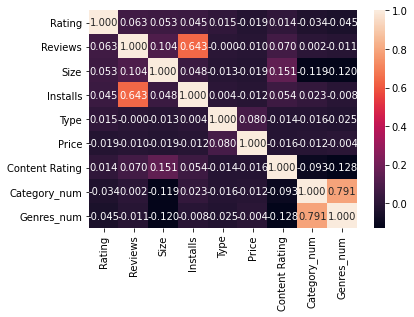

In [ ]:
sns.heatmap(full_df.corr(), annot=True, fmt='.3f')

In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10840
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Category        10840 non-null  object 
 1   Rating          10840 non-null  float64
 2   Reviews         10840 non-null  float64
 3   Size            10840 non-null  float64
 4   Installs        10840 non-null  float64
 5   Type            10840 non-null  int64  
 6   Price           10840 non-null  float64
 7   Content Rating  10840 non-null  int64  
 8   Genres          10840 non-null  object 
 9   Category_num    10840 non-null  int64  
 10  Genres_num      10840 non-null  int64  
 11  Type_Imputed    10840 non-null  object 
dtypes: float64(5), int64(4), object(3)
memory usage: 1.4+ MB


In [44]:
X = full_df.drop(["Rating", "Type_Imputed", "Price", "Category_num", "Category", "Genres"], axis=1)
y_add_categ = full_df["Rating"]

columns = X.columns
scaler = StandardScaler()
X_add_categ = scaler.fit_transform(X)
pd.DataFrame(X_add_categ, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,8.623458e-16,1.651623e-16,5.480344e-16,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-1.036705e+00,-1.818790e-01,-4.429954e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-7.527294e-01,-1.818672e-01,-4.429954e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-1.694996e-01,-1.807028e-01,-4.429954e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,2.161069e-01,-1.230730e-01,-4.429954e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.782967e+00,1.157931e+01,2.591488e+00,3.513515e+00,1.646057e+00


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_add_categ, y_add_categ,
                            test_size=0.2, random_state=88888888)

In [46]:
lin_add_categ = LinearRegression()
lin_add_categ.fit(X_train, y_train)
test_model(lin_add_categ)

mean_absolute_error: 0.30362650257631857
median_absolute_error: 0.21985375981385857
mean_squared_error: 0.211984730987518
r2_score: 0.010620578651417079


In [47]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=141,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [48]:
b_gs_add_categ = gs.best_estimator_
b_gs_add_categ.fit(X_train, y_train)
y_pred = b_gs_add_categ.predict(X_test)
test_model(b_gs_add_categ)

mean_absolute_error: 0.28133886615996073
median_absolute_error: 0.1808802928352582
mean_squared_error: 0.18917870334450723
r2_score: 0.11706133184901579


##Classification

In [49]:
full_df = new_df.copy()
full_df.drop('Type_Imputed', axis=1, inplace=True)

In [50]:
from sklearn.neighbors import KNeighborsClassifier

missing_columns = ['Type']
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
        
    deter_data["Det" + feature] = full_df[feature]
    parameters = list(set(full_df.columns) - set(missing_columns) - {'Category'} - {'Genres'})
    X_train = full_df[full_df['Type'].notnull()]
    X_train.drop(['Category', 'Genres', 'Type'], axis=1, inplace=True)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    y_train = full_df[full_df['Type'].notnull()]['Type']
    #y_train = le.fit_transform(y_train)
    
    #Create a Linear Regression model to estimate the missing data
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X = X_train, y = y_train)
    
    #observe that I preserve the index of the missing data from the original dataframe
    deter_data.loc[full_df[feature].isnull(), "Det" + feature] = model.predict(full_df[parameters])[full_df[feature].isnull()]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
deter_data.isnull().sum()

DetType    0
dtype: int64

In [51]:
full_df['Type'] = deter_data['DetType']
full_df.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Category_num      0
Genres_num        0
dtype: int64

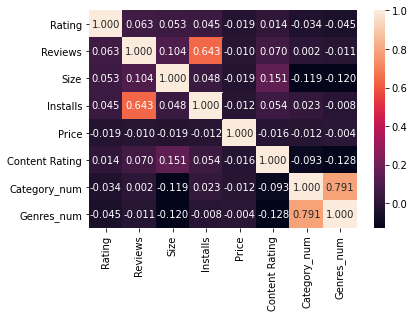

In [ ]:
sns.heatmap(full_df.corr(), annot=True, fmt='.3f')

In [52]:
type_num = le.fit_transform(full_df['Type'])
full_df['Type'] = type_num
print(np.unique(full_df['Type']))

[0 1]


In [53]:
#X = full_df.drop(["Rating", "Category_num", "Category", "Genres"], axis=1)
X = full_df.drop(["Rating", "Price", "Category_num", "Category", "Genres"], axis=1)
y_classif = full_df["Rating"]

columns = X.columns
scaler = StandardScaler()
X_classif = scaler.fit_transform(X)
pd.DataFrame(X_classif, columns=columns).describe()

,Reviews,Size,Installs,Type,Content Rating,Genres_num
count,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04,1.084000e+04
mean,-1.296690e-16,8.623458e-16,1.651623e-16,3.295939e-15,4.811086e-16,-8.467645e-15
std,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00
min,-1.517110e-01,-1.036705e+00,-1.818790e-01,-2.687113e-01,-1.456148e+00,-1.968561e+00
25%,-1.516980e-01,-7.527294e-01,-1.818672e-01,-2.687113e-01,-4.622153e-01,-8.045318e-01
50%,-1.509957e-01,-1.694996e-01,-1.807028e-01,-2.687113e-01,-4.622153e-01,8.380663e-02
75%,-1.330011e-01,2.161069e-01,-1.230730e-01,-2.687113e-01,-4.622153e-01,9.721450e-01
max,2.654511e+01,3.782967e+00,1.157931e+01,3.721467e+00,3.513515e+00,1.646057e+00


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_classif, y_classif,
                            test_size=0.2, random_state=88888888)

In [55]:
lin_classif = LinearRegression()
lin_classif.fit(X_train, y_train)
test_model(lin_classif)

mean_absolute_error: 0.304514279668469
median_absolute_error: 0.22137447479453742
mean_squared_error: 0.21174752717655076
r2_score: 0.011727661072604478


In [56]:
tuned_parameters = {
    "n_estimators": np.arange(1, 252, 10), # default 100
}

gs = GridSearchCV(BaggingRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=251,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [57]:
b_gs_classif = gs.best_estimator_
b_gs_classif.fit(X_train, y_train)
y_pred = b_gs_classif.predict(X_test)
test_model(b_gs_classif)

mean_absolute_error: 0.27875106900641994
median_absolute_error: 0.17296102797862245
mean_squared_error: 0.18713060100439374
r2_score: 0.12662027648943652


In [58]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='black')
        plt.show()  

In [59]:
# Модели
regr_models = {'Mode': {'model': lin_mode, 'X': X_mode, 'y': y_mode},
               'Add var':{'model': lin_add_var, 'X': X_add_var, 'y': y_add_var},
               'Add category':{'model': lin_add_categ, 'X': X_add_categ, 'y': y_add_categ},
               'Classification KNN':{'model': lin_classif, 'X': X_classif, 'y': y_classif},
              }

In [60]:
regrMetricLogger = MetricLogger()

In [61]:
def regr_train_model(model_name, model, X, y, regrMetricLogger):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.2, random_state=88888888)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MedAE', model_name, medae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)     
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MedAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(medae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [62]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model['model'], model['X'], model['y'], regrMetricLogger)

*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.304, MedAE=0.221, MSE=0.212, R2=0.012
*****************************************************
*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.304, MedAE=0.221, MSE=0.212, R2=0.012
*****************************************************
*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.304, MedAE=0.22, MSE=0.212, R2=0.011
*****************************************************
*****************************************************
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

MAE=0.305, MedAE=0.221, MSE=0.212, R2=0.012
*****************************************************


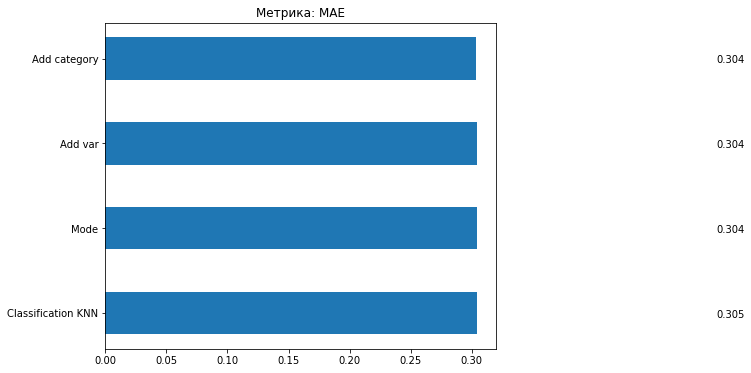

In [63]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', 
                      ascending=False, figsize=(7, 6))

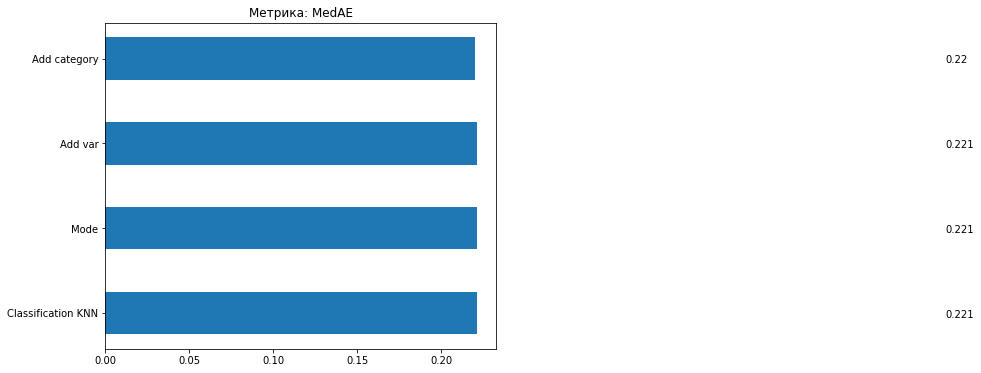

In [64]:
regrMetricLogger.plot('Метрика: ' + 'MedAE', 'MedAE', 
                      ascending=False, figsize=(7, 6))

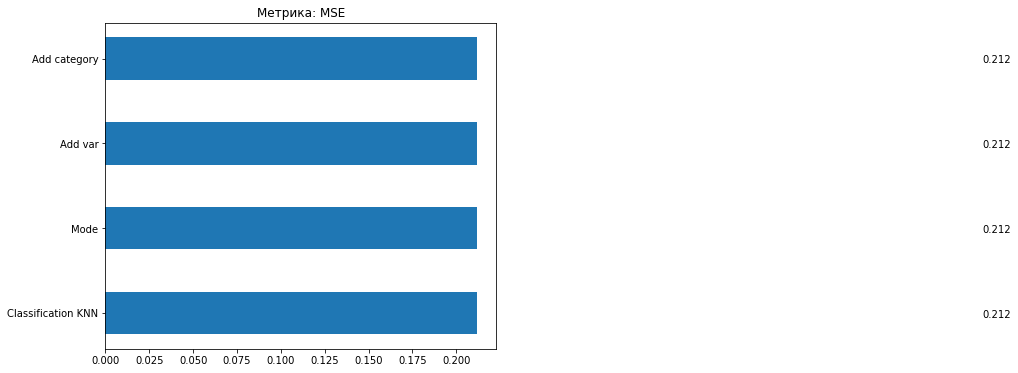

In [65]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE',
                      ascending=True, figsize=(7, 6))  

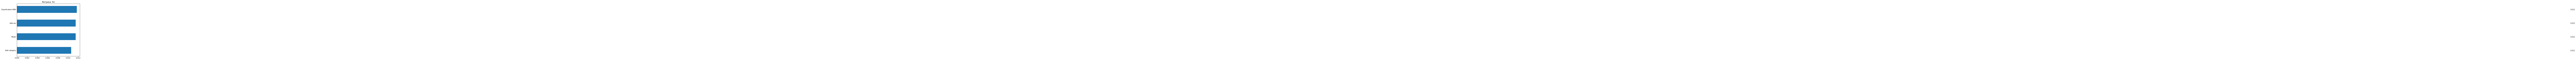

In [66]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2',
                      ascending=True, figsize=(7, 6))  

При заполнении пропусков в категориальной переменной отдам предпочтение введению дополнительной категории.

In [67]:
# Модели
regr_models = {'Mode': {'model': b_gs_mode, 'X': X_mode, 'y': y_mode},
               'Add var':{'model': b_gs_add_var, 'X': X_add_var, 'y': y_add_var},
               'Add category':{'model': b_gs_add_categ, 'X': X_add_categ, 'y': y_add_categ},
               'Classification KNN':{'model': b_gs_classif, 'X': X_classif, 'y': y_classif},
              }

In [68]:
regrMetricLogger = MetricLogger()

In [69]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model['model'], model['X'], model['y'], regrMetricLogger)

*****************************************************
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=251,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

MAE=0.278, MedAE=0.172, MSE=0.188, R2=0.124
*****************************************************
*****************************************************
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=241,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

MAE=0.279, MedAE=0.171, MSE=0.188, R2=0.122
*****************************************************
*****************************************************
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, m

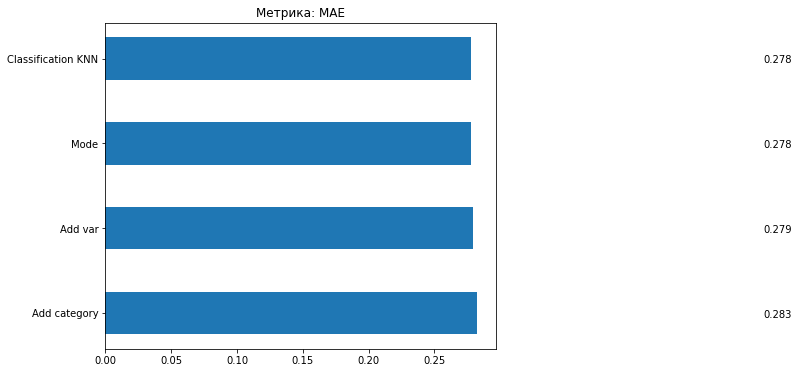

In [70]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', 
                      ascending=False, figsize=(7, 6))

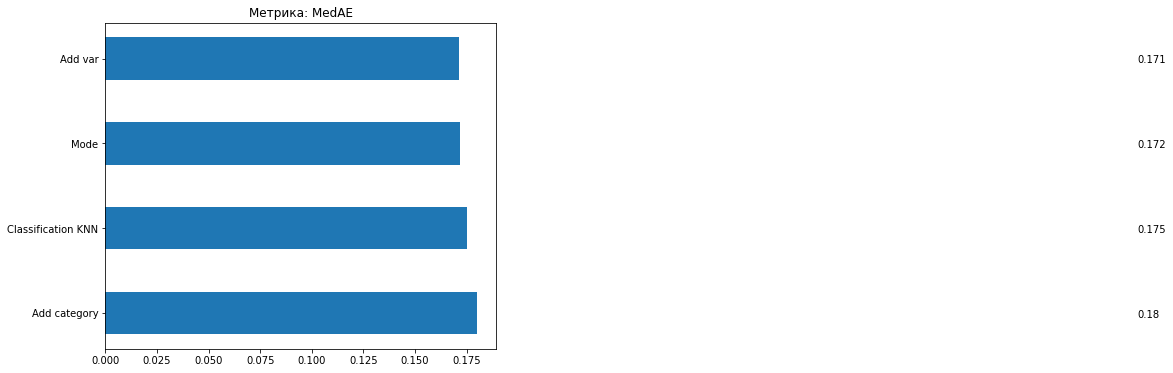

In [71]:
regrMetricLogger.plot('Метрика: ' + 'MedAE', 'MedAE', 
                      ascending=False, figsize=(7, 6))

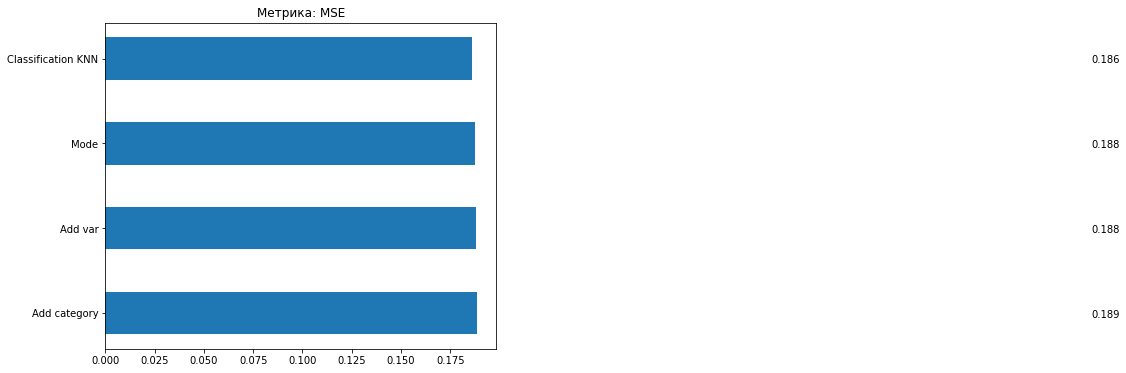

In [72]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', 
                      ascending=False, figsize=(7, 6))

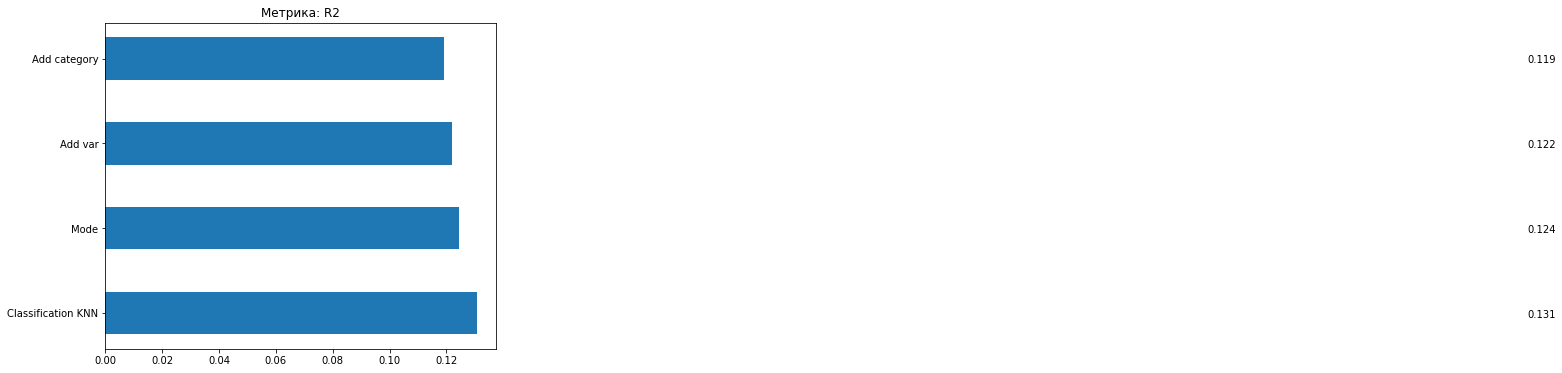

In [73]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', 
                      ascending=False, figsize=(7, 6))

Для модели Bagging импьютация с помощью введения дополнительной категории показывает результаты немного хуже, но отрыв не слишком большой.